<a href="https://colab.research.google.com/github/DeatnNote/pancard-checker/blob/main/sklearn_clustering_methods_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'clustering-exercises:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2133168%2F3549362%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240703%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240703T033804Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D44656f2e99baa11d14644a308eaf297ddb79b077dc25a75a053a76574bae1916758042b06231bb5200bea14abe792e2b1f4fcf7ed9099abbcf2e0da6c6f6bf065d933e001adb4ada2153ca1164b323b6f7d06e7c17babb27425e2e640d48886f1e4b2e8dcc9802422f08b17fb472201064f9b0ceb9893ddaa224b25e1ffa4a49ffa34676587a26fc26861f046b28532f772e82ebc68169d9cf8d1273ca600a5b099226185bceccffbc465e3fd03f2c62cb580cb4e123bff8df89d95257953a92ee24255ed56ea50cf76b031ebe7a1486b3b556180b0b3c537837bc65bf90ba8975e28376c1074b1064d35c29bb801ceb4f72232bfaa0d0acaa13bbf85cd15139'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3602272 bytes downloaded
Downloaded and uncompressed: clustering-exercises
Data source import complete.


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore", UserWarning)

csv_files = []
for dirname, _, filenames in os.walk('../input/clustering-exercises'):
    for filename in sorted(filenames):
        csv_files.append(os.path.join(dirname, filename))

# Utils

In [4]:
def invert_rgb(h):
    rgb = [h[1:3], h[3:5], h[5:]]
    rgb = list(map(lambda x: int(255 - int(x, 16)), rgb))
    return '#' + ''.join(map('{:02x}'.format, rgb)).upper()

In [5]:
import matplotlib as mpl

def color_gradient(c1, c2, mix_rate=0.0):
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix_rate)*c1 + mix_rate*c2)

In [6]:
def create_n_colors(n):
    a = []
    for i in range(n):
        r = i / n
        c = ''
        if r < 1 / 3:
            c = color_gradient('red', 'blue', r * 3)
        elif r < 2 / 3:
            c = color_gradient('blue', 'green', (r - 1/3) * 3)
        else:
            c = color_gradient('green', 'red',  (r - 2/3) * 3)
        a.append(c)
    return a

In [7]:
def plot_df(df, colors, **kwargs):
    cmap = create_n_colors(len(set(colors)))
    c = list(map(lambda x: cmap[x], colors))
    return sns.scatterplot(data=df, x='x', y='y', c=c, **kwargs)

In [8]:
def sec(start_time, end_time):
    diff = end_time - start_time
    s, ms = diff.seconds, diff.microseconds
    return f'{s}.{str(ms)[:2]}'

In [9]:
import math
from datetime import datetime

def benchmark(files, suptitle, callback, figsize=(5, 5), **kwargs):
    COLS = 6
    ROWS = math.ceil(len(files) / COLS)
    ROWS += int(ROWS == 1)
    fig, axes = plt.subplots(ROWS, COLS, figsize=figsize)
    plt.suptitle(suptitle, fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(**kwargs)
    mean_times = []
    for i, csv in enumerate(files):
        r, c = i // COLS, i % COLS
        ts = datetime.now()
        items, tm = callback(pd.read_csv(csv), ax=axes[r][c])
        if type(tm) == type(None):
            tm = sec(ts, datetime.now())
        else:
            tm = sec(tm[0], tm[1])
        title = axes[r][c].get_title()
        axes[r][c].set_title(title+'\n'+f'{items} items ({tm}sec)')
        mean_times.append(items / float(tm))
    print(suptitle, 'process average {:.2f} item(s)/sec'.format(np.mean(mean_times)))
    for ax in axes.flatten():
        ax.axis('off')
    fig.show()

# Preview a sample

In [19]:
df = pd.read_csv(csv_files[6])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


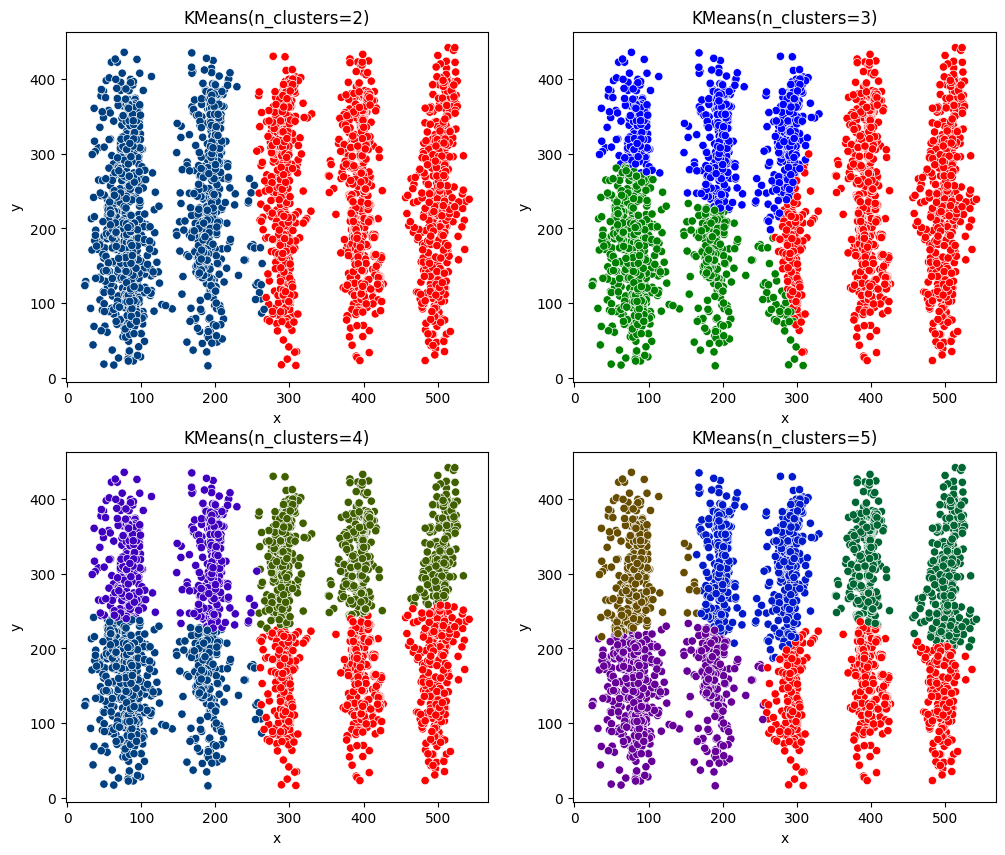

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, n_cluster in enumerate([2, 3, 4, 5]):
    kmeans = cluster.KMeans(n_clusters=n_cluster).fit(df[['x', 'y']])
    axes[i//2][i%2].set_title(f'KMeans(n_clusters={n_cluster})')
    plot_df(df, kmeans.labels_, ax=axes[i//2][i%2])
fig.show()

# Labels on Dataset

Answer Labels process average 33645.58 item(s)/sec


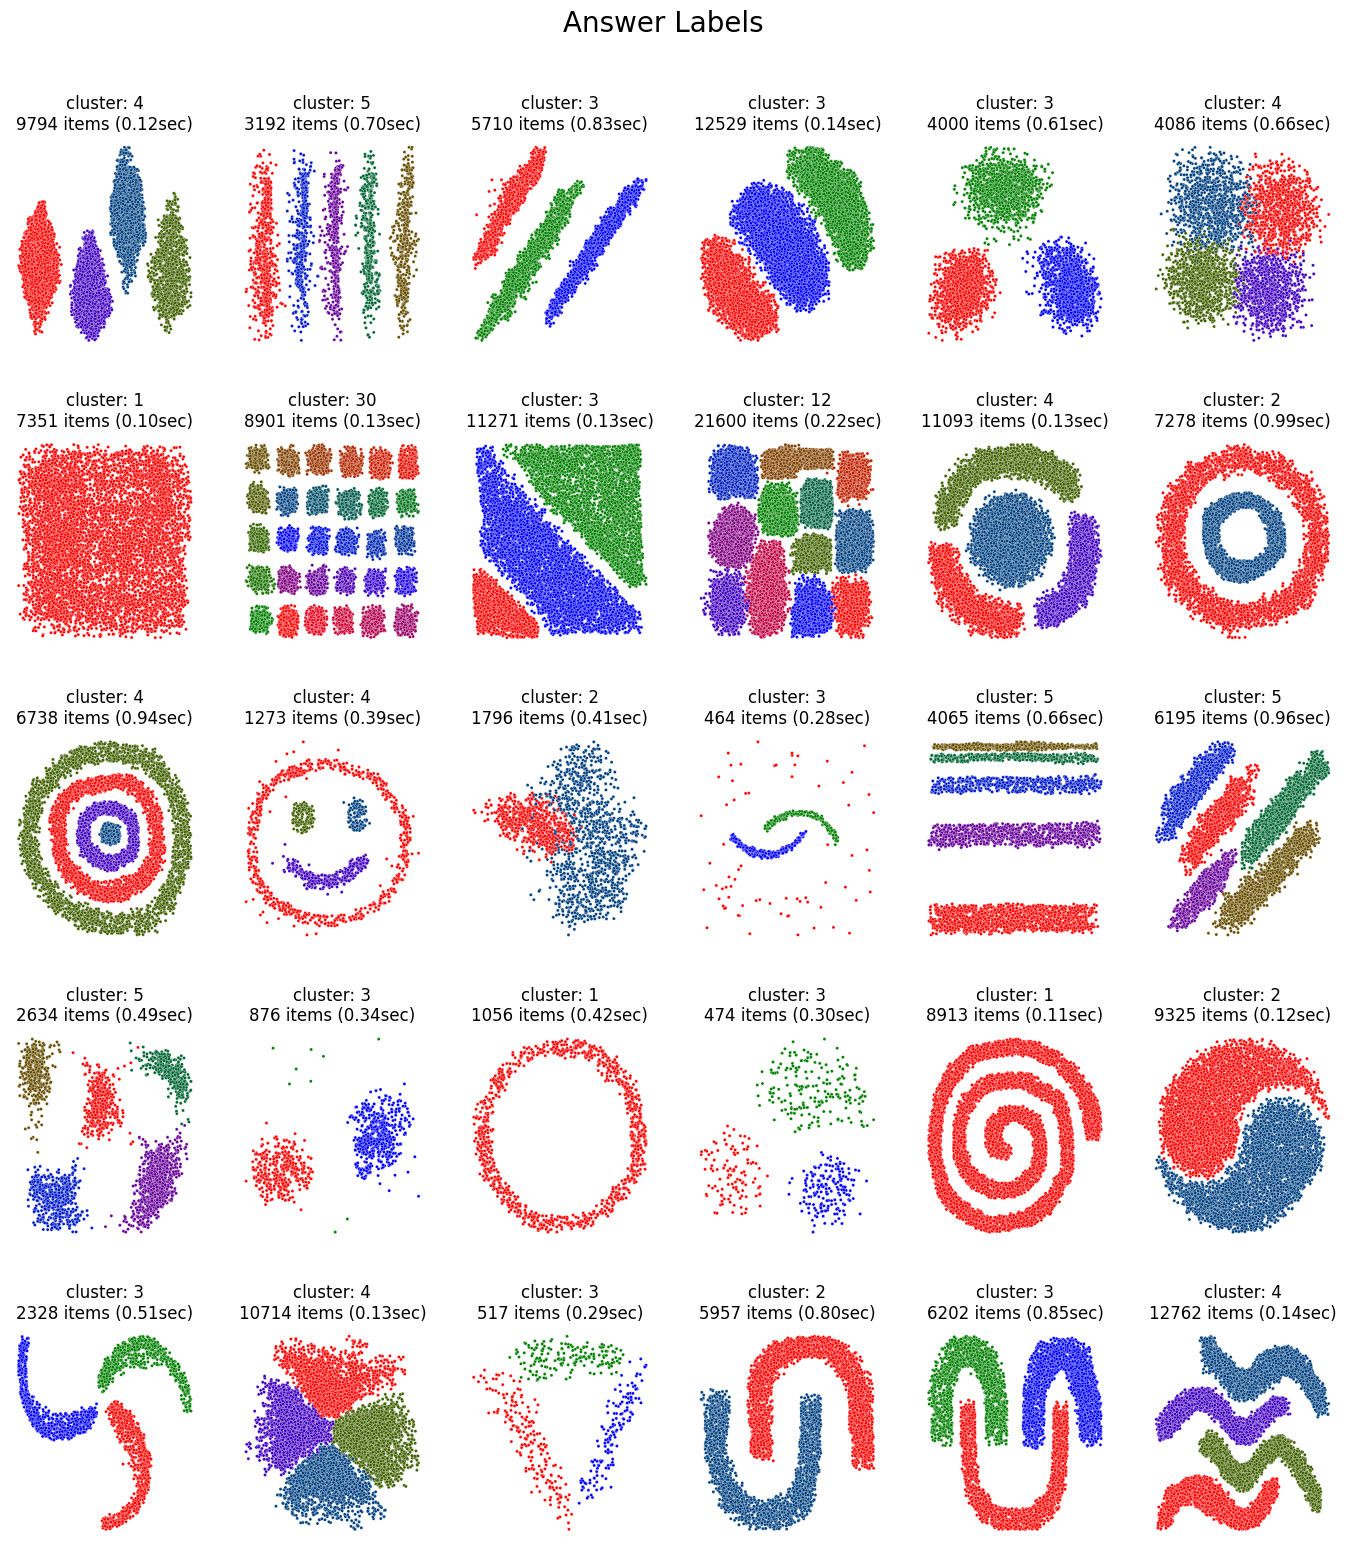

In [16]:
def label_answer(df, ax):
    labels = df['color']
    answer = len(set(labels))
    plot_df(df, labels, ax=ax, s=5)
    info = f'cluster: {answer}'
    ax.set_title(info)
    return len(df), None

benchmark(csv_files, 'Answer Labels', label_answer, figsize=(14, 16), wspace=0.2, hspace=0.4, top=0.9)

# AffinityPropagation

This takes too looooong time, so removed from this kernel.

In [ ]:
# %%time

# def affinity(df, ax):
# #     df = df.sample(frac=0.5)
#     answer = len(df['color'].unique())
#     labels = cluster.AffinityPropagation().fit_predict(df[['x', 'y']])
#     label_count = len(set(labels))
#     plot_df(df, labels, ax=ax, s=5)
#     info = f'cluster: {label_count}'
#     ax.set_title(info)
#     return len(df), None

# benchmark(csv_files, 'Affinity Propagation', affinity, figsize=(14, 16), wspace=0.2, hspace=0.4, top=0.9)

# K-Means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

K Means process average 10532.00 item(s)/sec
CPU times: user 21.1 s, sys: 8.01 s, total: 29.1 s
Wall time: 21.3 s


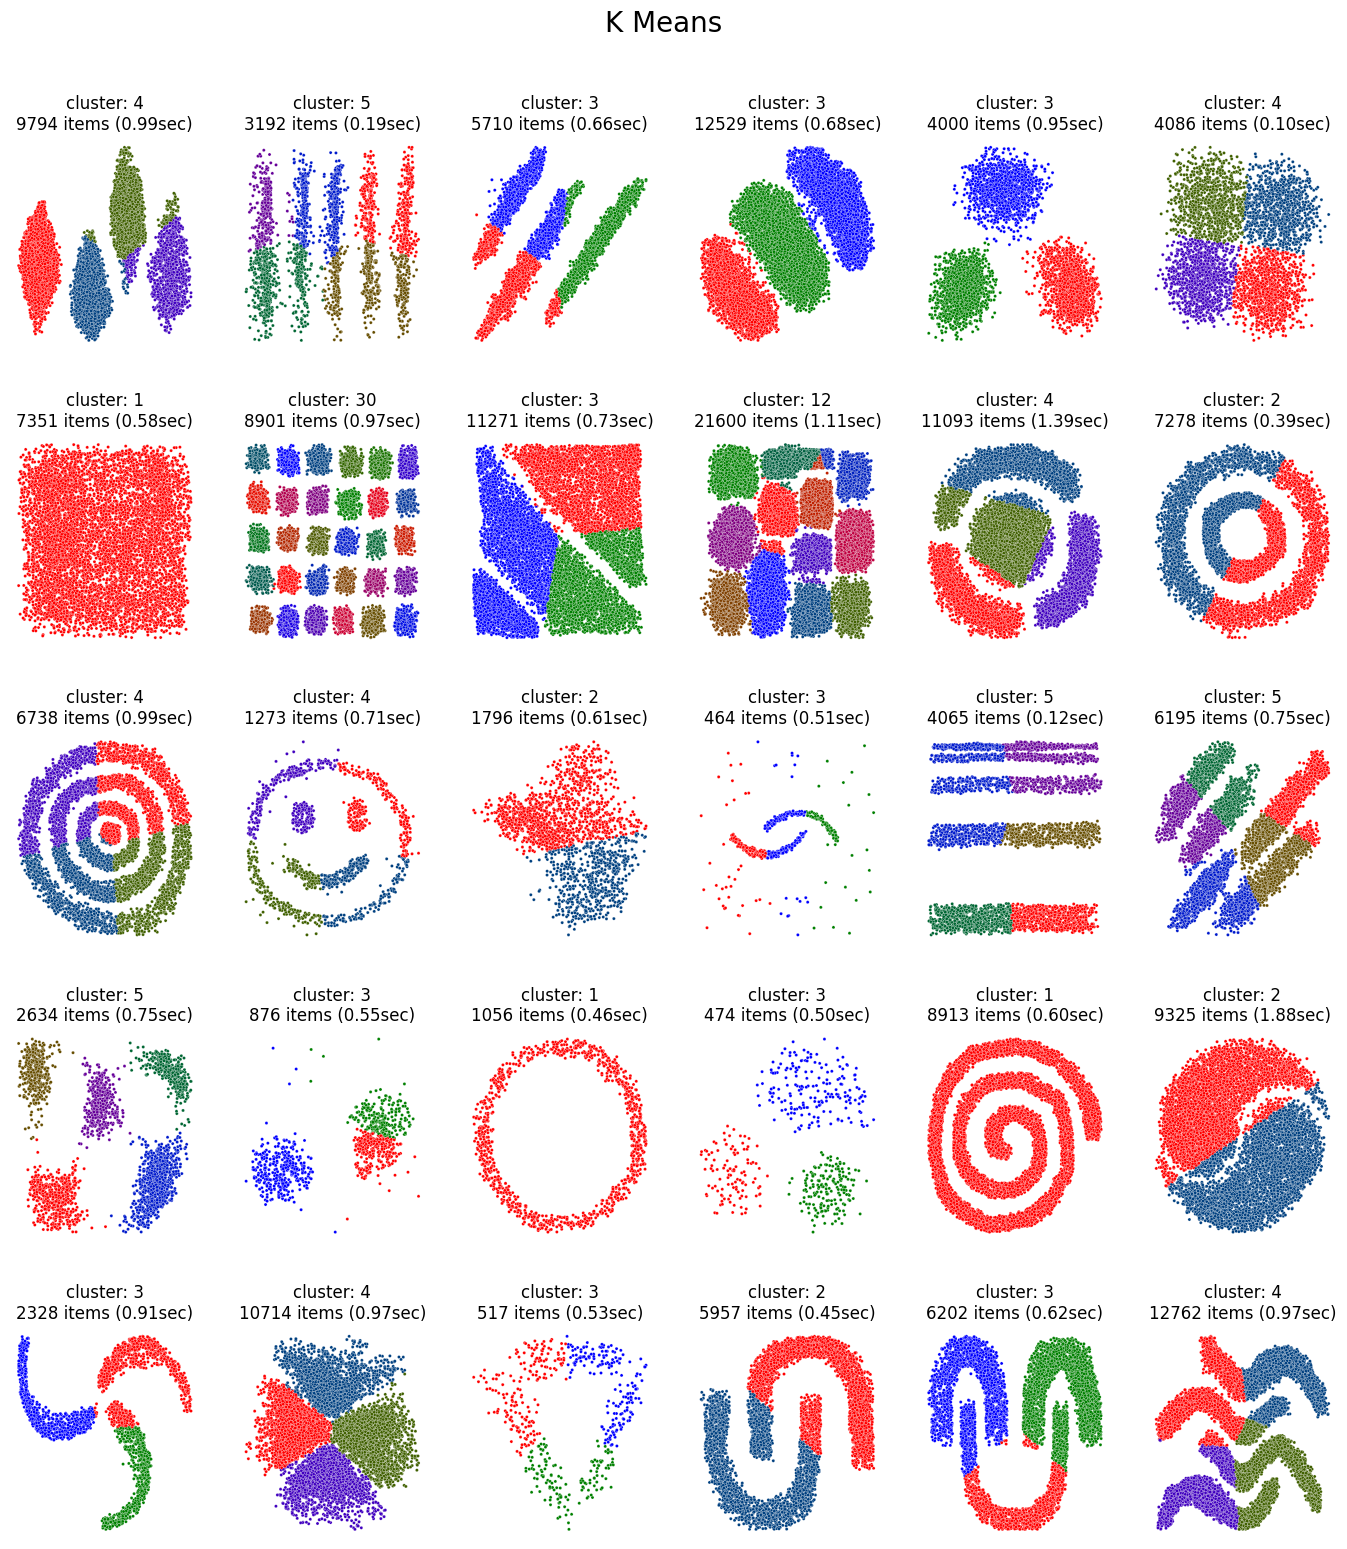

In [20]:
%%time

def kmeans(df, ax):
#     df = df.sample(frac=0.5)
    answer = len(df['color'].unique())
    labels = cluster.KMeans(n_clusters=answer).fit_predict(df[['x', 'y']])
    label_count = len(set(labels))
    plot_df(df, labels, ax=ax, s=5)
    info = f'cluster: {label_count}'
    ax.set_title(info)
    return len(df), None

benchmark(csv_files, 'K Means', kmeans, figsize=(14, 16), wspace=0.2, hspace=0.4, top=0.9)